<h1 style="background-color:#a83299;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 20px 20px;font-family:cursive">Clustering text documents and Giving Recommendation Using K-means</h1>

### Pre-condition to Run ###
1. Ensure the data subfolder has four files:
    a. arxiv-metadata-ext-category.csv
    b. arxiv-metadata-ext-citation.csv
    c. arxiv-metadata-ext-taxonomy.csv
    d. arxiv-metadata-ext-version.csv
    e. arxiv-cs-papers-normalized.csv

    If those files do not exist, please run get_clean_text.py, line 62, the function `load_cs_papers("")` and line 65, `load_cs_papers("", "normalized", run_preprocessor=True)` to get those files ready.

2. If you want to re-train those word2vec, Kmeans models, etc., set variable `FAST_RUN_WITH_EXISTING_DATA` in the first cell to False. You could start to run the cells in sequence (skip the step 3). The whole model building process might take 1.2 hours.

3. If you want to use the existing trained models and other data, skip step 2.copy the data from this address: to your project folder. Ensure those files are put under <project folder>/model_data/. Keep `FAST_RUN_WITH_EXISTING_DATA` variable to True, and you could start to run the code in sequence.

In [ ]:
# !pip install gensim
# !pip install wordcloud

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import kmeans_classify
pd.options.display.max_seq_items = 1000

FAST_RUN_WITH_EXISTING_DATA = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the pre-existing csv files into dataframes. Please ensure those .csv files exist in subfolder "data". If the .csv file does not exist, you need to run get_clean_text.py, line 62, `cs_papers = load_cs_papers("")` to download and process the abstract text.

In [3]:
# Prepare the dataframes 

df_citations = pd.read_csv("data/arxiv-metadata-ext-citation.csv",dtype={"id":object,"id_reference":object})
print("total records of df:citations:", df_citations.shape)

df_categories = pd.read_csv("data/arxiv-metadata-ext-category.csv",dtype={"id":object,"category_id":object})
print("total records of df:categories:", df_categories.shape)

df_taxonomy = pd.read_csv("data/arxiv-metadata-ext-taxonomy.csv")
print("total records of df_taxonomy:",df_taxonomy.shape)

df_versions = pd.read_csv("data/arxiv-metadata-ext-version.csv", dtype={'id': object})
print("total records of df_versions:",df_versions.shape)


total records of df:citations: (6849633, 2)
total records of df:categories: (4173480, 2)
total records of df_taxonomy: (155, 6)
total records of df_versions: (2455227, 3)


Load the .csv file and concatenate with df_categories and df_taxonomy, so that the returned dataframe data_df contains more complete information about the paper. Please note:

a. A new field called "year" is added when you call the following function `kmeans_classify.concatenate_data`. The "year" field represents the published year of the paper. 
b. The abstract fields remove stop words of English in this function.

Exploratory Data Analysis: It is optional to call the function `view_top_category_paper_amount`. It is used to choose the top categories which contains the most amount of published paper. The result is shown in the diagram. The returned value records the list of all those top categories.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Claud\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


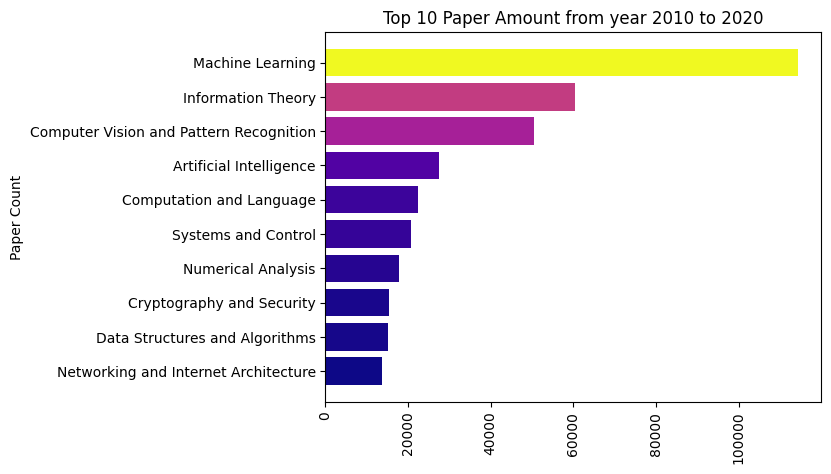

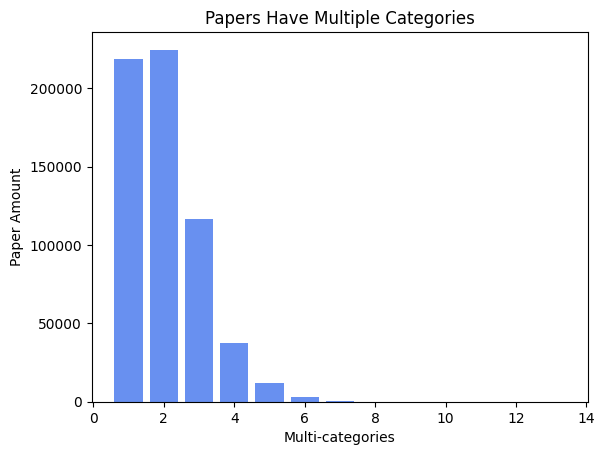

In [8]:
# concatenate data_df with df_categories, df_taxonomy to involve more info about the paper
if FAST_RUN_WITH_EXISTING_DATA:
    data_df = pd.read_csv("model_data/data_df.csv", dtype={"id":object})
else:
    # take about 16 mins.
    data_df =  pd.read_csv("data/arxiv-cs-papers-normalized.csv", dtype={"id":object})
    data_df = kmeans_classify.concatenate_data(data_df, df_categories, df_taxonomy, remove_stop_words = True)
    
top_categories = kmeans_classify.view_top_category_paper_amount(data_df, 10, 2010, 2020)

## Text Document Clustering ##

Cluster documents using K-means algorithm:
1. Convert words into vectors by using word2vec.
2. Convert each doc into a vector by averaging all the word vectors in the doc.
3. Use k-means clustering to perform unsupervised clustering of the documents.
4. Check clustering quality by using metrics such as homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score and silhouette_score

In [10]:
# when annual meta data merges with categories, taxonomy, there are duplicated records because one paper could belong to more than one category. We drop those duplicate paper records.
data_df = data_df.drop_duplicates(["id"])

if FAST_RUN_WITH_EXISTING_DATA:

    # load from the pre-processed models and show efficiency measures
    word_vectorizer = kmeans_classify.load_from_pickle("model_data/word2vec_model.pkl")
    vectorized_docs = kmeans_classify.load_from_pickle("model_data/vectorized_docs.pkl")
    km_model = kmeans_classify.load_from_pickle("model_data/km_model.pkl")
    kmeans_classify.check_kmean_efficiency(km_model, data_df, vectorized_docs)
else:
    ##### only need to create once / or update those models when necessary. Most of conditions, we only need to load the existing models from pickle files. Once running, the pickle files got updated automatically with the new model data.
    word_vectorizer, vectorized_docs = kmeans_classify.generate_word_and_doc_vectors(data_df)       # 30+ mins.
    km_model = kmeans_classify.fit_kmean_model(40, vectorized_docs) #17 mins.


Generating word vectors... Take 30+ mins.
Starting vectorizing docs 0-5000
Starting vectorizing docs 5000-10000
Starting vectorizing docs 10000-15000
Starting vectorizing docs 15000-20000
Starting vectorizing docs 20000-25000
Starting vectorizing docs 25000-30000
Starting vectorizing docs 30000-35000
Starting vectorizing docs 35000-40000
Starting vectorizing docs 40000-45000
Starting vectorizing docs 45000-50000
Starting vectorizing docs 50000-55000
Starting vectorizing docs 55000-60000
Starting vectorizing docs 60000-65000
Starting vectorizing docs 65000-70000
Starting vectorizing docs 70000-75000
Starting vectorizing docs 75000-80000
Starting vectorizing docs 80000-85000
Starting vectorizing docs 85000-90000
Starting vectorizing docs 90000-95000
Starting vectorizing docs 95000-100000
Starting vectorizing docs 100000-105000
Starting vectorizing docs 105000-110000
Starting vectorizing docs 110000-115000
Starting vectorizing docs 115000-120000
Starting vectorizing docs 120000-125000
Sta

c:\Users\Claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


### Recommend papers by responding to user query

There are two choices to recommend papers.
First choice: choose by comparing keywords of each doc with user input. However, this method is more accurate but time-consuming. It does not use the pre-training result of KMeans.

Second choice: choose by comparing the user query's doc distance to the cluster_centers. This project will use this method. Kmean model's predict method accepts the user query's doc ventor as input, and predict the closest cluster the doc belongs to.


-------------------------------------------
Top 5 papers closest to the center of Cluster 0
           id                                              title
0  1801.06593  A Foreground Inference Network for Video Surve...
1  2402.04584  Troublemaker Learning for Low-Light Image Enha...
2  1806.05372  Multi-Attention Multi-Class Constraint for Fin...
3  2207.09792  Unsupervised Industrial Anomaly Detection via ...
4  2311.18286  SimulFlow: Simultaneously Extracting Feature a...
Top 10 keywords closest to the center of Cluster 0
['image', 'instancelevel', 'discriminative', 'objectlevel', 'feature', 'pixellevel', 'semantic', 'patchwise', 'crossattention', 'selfsupervision']

Cluster 0's top 10 most cited papers:
           id                                              title
0   1310.1531  DeCAF: A Deep Convolutional Activation Feature...
1   1312.6034  Deep Inside Convolutional Networks: Visualisin...
2   1312.6229  OverFeat: Integrated Recognition, Localization...
3   1411.2539  Unify

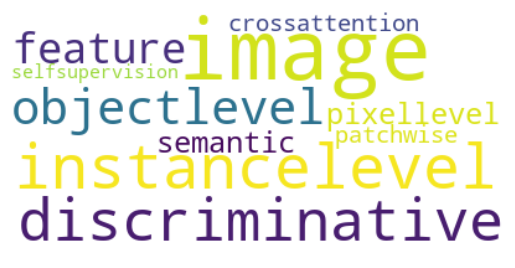


-------------------------------------------
Top 5 papers closest to the center of Cluster 1
           id                                              title
0  2003.11323  Plausible Counterfactuals: Auditing Deep Learn...
1  2007.03924  Winning with Simple Learning Models: Detecting...
2  2306.14349  Utilizing deep learning for automated tuning o...
3  2310.09780  Notes on Applicability of Explainable AI Metho...
4  1608.06581  Fathom: Reference Workloads for Modern Deep Le...
Top 10 keywords closest to the center of Cluster 1
['learning', 'models', 'multimodal', 'nlp', 'humancentric', 'machinelearning', 'domainspecific', 'explainability', 'metalearning', 'unsupervised']

Cluster 1's top 10 most cited papers:
           id                                              title
0   1408.5093  Caffe: Convolutional Architecture for Fast Fea...
1   1410.3831  An exact mapping between the Variational Renor...
2  1508.06576               A Neural Algorithm of Artistic Style
3  1606.03490       

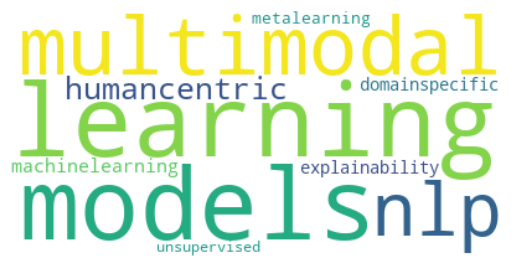

In [18]:
# If you want to know each cluster's keywords, top cited papers, generate word cloud for top keywords, call this method
for i in range(2):
    kmeans_classify.report_cluster_info(i, word_vectorizer, km_model, data_df, df_citations, vectorized_docs)
    

this input is closest to this cluster 6

-------------------------------------------
Top 5 papers closest to the center of Cluster 6
           id                                              title
0  1501.07315  Per-Block-Convex Data Modeling by Accelerated ...
1  1809.10491  On the Regret Minimization of Nonconvex Online...
2  2111.01040  STORM+: Fully Adaptive SGD with Momentum for N...
3  2008.10103  Single-Timescale Stochastic Nonconvex-Concave ...
4  2202.03397  Bilevel Optimization with a Lower-level Contra...
Top 10 keywords closest to the center of Cluster 6
['primaldual', 'convex', 'leastsquares', 'approximation', 'minimax', 'minmax', 'approximate', 'convexconcave', 'saddlepoint', 'primal']

Cluster 6's top 10 most cited papers:
           id                                              title
0   1009.5055  The Augmented Lagrange Multiplier Method for E...
1   1012.2599  A Tutorial on Bayesian Optimization of Expensi...
2   1309.2388  Minimizing Finite Sums with the Stochasti

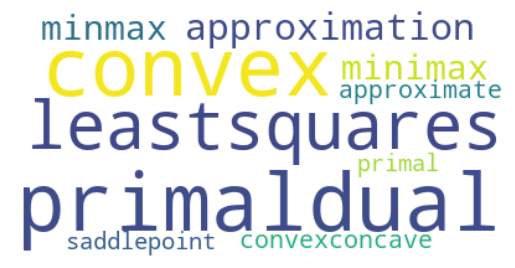

In [24]:
# get user unput vector
user_input = "deep learning algorithm optimization"
kmeans_classify.predict_user_query_cluster(user_input, word_vectorizer, km_model, data_df, df_citations, vectorized_docs)

